In [1]:
import torch
import random
import pandas as pd
import numpy as np
from IPython.display import clear_output
import torch
from torchvision import transforms
import warnings


# to ignore torchvision model warnings
warnings.filterwarnings(
    action='ignore',
    category=DeprecationWarning,
    
    module=r'.*randpool'
)

# **Overview**
<font size="3">
This Notebook aims to demonstrate one of the inherent weaknesses of using convolutional neural networks (CNN's) in safety critical systems such as security systems, autonomous driving applications and more. The notebook offers a walk through of the steps and code necessary for you to understand the concepts involved and to try out the idea for yourself. Please feel free to re-use any code you see in this document.

* <pre> demo.ipynb   ->  demonstration notebook to follow along</pre> 
*  <pre> image.py     ->  supporting python file that provides the Image class and additional functionality I created</pre> 
</br>
</font>



## The weakness
<font size="3">**The Architecture:**
CNN's and NN's rely on precise weights that have been calibrated through the propagation of training errors to correct these prediction weights that are stored in the neurons of the hidden layers in the networks.</font>
</br></br>
<font size="3">**The Hypotheses:**
If we had access the the model (and therefore the neuron weights) used in these safety critical systems we could potential exploit their over reliance on particular neurons and their associated weights to adjust the model predictions to our benefit.</font>
</br></br>
<font size="3">**The Approach:**
This notebook uses the famous ResNet-18 model as an example of how these weights can be used to our advantage as well as some new arbitrary and unseen images for the model to make predictions on.</font>




In [2]:
from PIL import Image

<font size="3">We will be using the Python Imaging Library (PIL) to make precise changes to our images</font>

In [3]:
our_banana_raw = Image.open('/Users/ted.taylor/Downloads/ban.jpg')
print(f"Original size : {our_banana_raw.size}") # 5464x3640

our_banana = our_banana_raw.resize((256, 256))

Original size : (1200, 1057)


<font size="3">Now we need to import an example image for the model to make predictions on, in this case our example image is just a banana</font>

In [10]:
from image import Image, pred

# to ignore torchvision model warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning,module=r'.*randpool')

<font size="3">We should also import our supporting python file  (and the pred method) which contains many of the supporting methods I created </font>

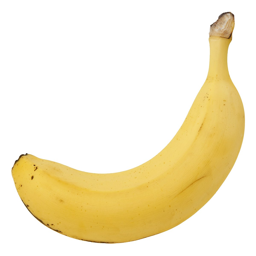

In [7]:
our_image = Image(our_banana)
our_image.matrix

<font size="3">We can then create an Image object by passing in our image we loaded, we can then view this image using the .matrix function on our Image object</font>


In [20]:
print(f"{len(pred(our_image.matrix))}\n")
pred(our_image.matrix,5)

1000



[('banana', 99.97368621826172),
 ('hook', 0.00846079457551241),
 ('lemon', 0.005604405887424946),
 ('slug', 0.0033339131623506546),
 ('spaghetti squash', 0.0027643986977636814)]

<font size="3">By passing our image to the pred() function we can see it returns a list containing 1000 elements, we can also pass in an integer to limit the results to the top 'n' predictions, in this case we only really want to look at the top 5</font>
</br> </br> 
<font size="3">**As we can see the ResNet-18 model stored within the image file is ~99.9% sure our image is a banana!** </font>
</br> </br> 
<font size="3"> Lets aim to trick the model into thinking this banana is a 'golf ball' to the point where it is 99% confident</font>


In [ ]:
white_image = our_banana_raw.resize((256, 256))
for i in range(0,255):
    for j in range(0,255):
        white_image.load()[i,j] = (255,255,255)
black_image = our_banana_raw.resize((256, 256))
for i in range(0,255):
    for j in range(0,255):
        black_image.load()[i,j] = (0,0,0)

# Thoughts on improvements ?
<br>- Count what colors and sizes using in plots - once it gets to 25% restart with most common color-size weights increased proba
<br>- use k counter to nudge out of a local minimum - create thick white border around edge of image to nudge along
<br>- total pixel value count - if less than 1/4 of pixels != 255,255,255 at 25% restart process (avoids creating small objects/ noise)